In [ ]:
!pip install yfinance

In [2]:
!pip install hurst

  Using cached hurst-0.0.5-py3-none-any.whl.metadata (3.6 kB)
Using cached hurst-0.0.5-py3-none-any.whl (5.9 kB)


In [3]:
!pip install pandas

In [4]:
!pip install nolds

  Using cached nolds-0.6.2-py2.py3-none-any.whl.metadata (7.0 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
Using cached nolds-0.6.2-py2.py3-none-any.whl (225 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nolds]]


In [1]:
# Paso 1: Descargar los datos históricos del S&P 500 y calcular los log-retornos

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.1 Descargamos datos del S&P 500 (índice completo)
ticker = "^GSPC"
data = yf.download(ticker, start="2000-01-01", end="2025-01-01")  # Últimos 25 años

# 1.2 Usamos el precio de cierre ajustado
prices_SP = data["Close"]
print(prices_SP)

# 1.3 Calculamos los log-retornos diarios
log_returns_SP = np.log(prices_SP / prices_SP.shift(1)).dropna()

# 1.4 Mostramos una visualización
plt.figure(figsize=(12,4))
plt.plot(log_returns_SP, label='Log-retornos diarios del S&P 500')
plt.title("Log-retornos del S&P 500 (2000-2025)")
plt.xlabel("Fecha")
plt.ylabel("Log-retorno")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'yfinance'

In [64]:
# Paso 2: Descargar datos sectoriales del S&P 500 y construir la malla espacial

# ETFs representativos de los sectores del S&P 500
sector_etfs = {
    "XLF": "Finanzas",
    "XLK": "Tecnología",
    "XLV": "Salud",
    "XLY": "Consumo discrecional",
    "XLP": "Consumo básico",
    "XLI": "Industriales",
    "XLE": "Energía",
    "XLRE": "Inmobiliario",
    "XLU": "Utilities",
    "XLB": "Materiales",
    "XLC": "Transportes"
}

import datetime

✅ Log-retornos calculados exitosamente:
Ticker           XLF       XLK       XLE       XLV       XLY       XLI  \
Date                                                                     
2018-06-20 -0.002563  0.002098  0.004405  0.002119  0.004730  0.000682   
2018-06-21 -0.002937 -0.007713 -0.018689 -0.005779 -0.007149 -0.012634   
2018-06-22 -0.004791 -0.003244  0.019755  0.004485 -0.001705  0.003449   
2018-06-25 -0.010771 -0.020981 -0.020298 -0.009226 -0.021979 -0.012751   
2018-06-26 -0.003366  0.004031  0.012550 -0.003095  0.007137  0.003759   

Ticker           XLB      XLRE       XLU       XLC  
Date                                                
2018-06-20 -0.003254  0.010736  0.000797  0.012334  
2018-06-21 -0.010691  0.005949  0.003379 -0.006148  
2018-06-22  0.014458  0.008704  0.006920  0.004367  
2018-06-25 -0.015672 -0.002479  0.016416 -0.020813  
2018-06-26  0.003811  0.005261  0.001162  0.001657  


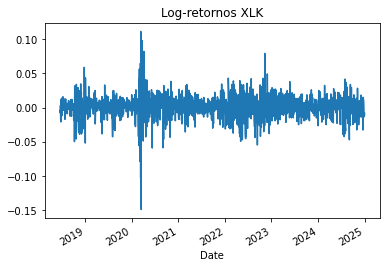

In [83]:
# Lista de ETFs sectoriales del S&P 500
sector_symbols = ['XLF', 'XLK', 'XLE', 'XLV', 'XLY', 'XLI', 'XLB', 'XLRE', 'XLU', 'XLC']

sector_prices = {}

for symbol in sector_symbols:
    data = yf.download(symbol, start="2018-01-01", end="2025-01-01", progress=False)
    
    # Verificamos que existe la columna 'Close' y no esté vacía
    if not data.empty and 'Close' in data.columns:
        close_series = data['Close'].copy()
        close_series.name = symbol  # Nombre explícito
        sector_prices[symbol] = close_series
    else:
        print(f"❌ No se pudieron obtener datos de cierre para: {symbol}")

# Combinar en DataFrame y alinear temporalmente
sector_df = pd.concat(sector_prices.values(), axis=1).dropna()

# Construimos el diccionario de precios por sectores
prices_dict = {
    ticker: sector_df[ticker].values.flatten()
    for ticker in sector_symbols
}

# Calcular log-retornos
sector_returns = np.log(sector_df / sector_df.shift(1)).dropna()

print("Log-retornos calculados:")
print(sector_returns.head())

# Como ejemplo, hacemos un plot de los log-retornos del sector de Tecnología
sector_returns["XLK"].plot(title="Log-retornos XLK")
plt.show()

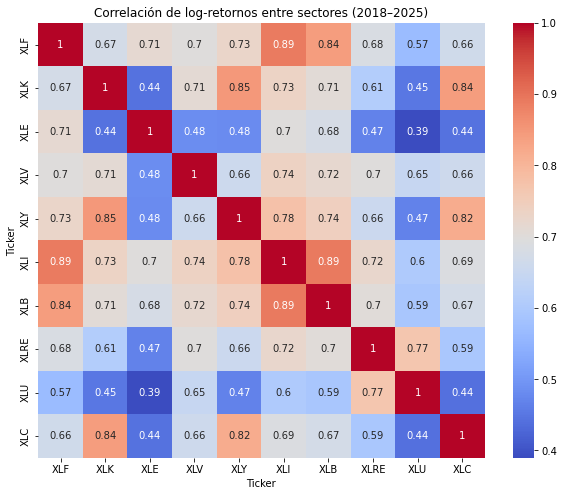

Orden óptimo de sectores para malla espacial (x):
['XLY', 'XLK', 'XLC', 'XLU', 'XLV', 'XLRE', 'XLE', 'XLF', 'XLI', 'XLB']


In [84]:
# 2.4 Calcular matriz de correlación
correlation_matrix = sector_returns.corr()

# 2.5 Visualizar matriz de correlación
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlación de log-retornos entre sectores (2018–2025)")
plt.show()

# 2.6 Ordenar sectores jerárquicamente por similitud de correlación
from scipy.cluster.hierarchy import linkage, leaves_list

linked = linkage(correlation_matrix, method='ward')
order = leaves_list(linked)

# Reordenamos los símbolos de los ETFs según correlación
ordered_symbols = correlation_matrix.columns[order].tolist()

print("Orden óptimo de sectores para malla espacial (x):")
print(ordered_symbols)

In [85]:
# Aseguramos que las columnas estén en el mismo orden que ordered_symbols
sector_returns = sector_returns[ordered_symbols]
sector_df = sector_df[ordered_symbols]

In [86]:
# Paso 3: Estimar parámetros del modelo a partir de log-retornos sectoriales

# Opción 1: μ y σ se calculan globalmente (promedio de todos los sectores)
mu_estimate = sector_returns.mean().mean()      # Media de todos los sectores
sigma_estimate = sector_returns.std().mean()    # Volatilidad media

print(f"μ (crecimiento medio): {mu_estimate:.6f}")
print(f"σ (volatilidad promedio): {sigma_estimate:.6f}")

μ (crecimiento medio): 0.000411
σ (volatilidad promedio): 0.015031


In [87]:
# Opción 2: μ y σ de los log-retornos se calculan sector a sector y se guardan en diccionarios
mu_dict = {}
sigma_dict = {}

for sector in ordered_symbols:
    returns = sector_returns[sector].dropna()
    mu_dict[sector] = returns.mean()
    sigma_dict[sector] = returns.std()

print(mu_dict)

{'XLY': 0.000462168061503137, 'XLK': 0.0007581666382752711, 'XLC': 0.0004390537718143177, 'XLU': 0.0003761916210322962, 'XLV': 0.0003612450664746978, 'XLRE': 0.00029022536794663575, 'XLE': 0.00026660838841020146, 'XLF': 0.00042491423621576654, 'XLI': 0.00042682534091723697, 'XLB': 0.0003024215971969426}


In [88]:
# 3.2 Estimación de α (orden fraccional) usando el exponente de Hurst para el SP500

from hurst import compute_Hc

# Usamos la serie del S&P 500 como referencia
hurst_exponent, _, _ = compute_Hc(prices_SP, kind='price', simplified=True)
alpha_SP = hurst_exponent

print(f"α (memoria temporal estimada del SP500 - Hurst): {alpha_SP:.4f}")

α (memoria temporal estimada del SP500 - Hurst): 0.7184


In [89]:
# 3.2 Estimación de α (orden fraccional) usando el exponente de Hurst para los log-retornos sector a sector

hurst_dict = {}

for ticker in ordered_symbols:
    series = sector_returns[ticker].dropna()
    try:
        H, _, _ = compute_Hc(series.values, kind='change', simplified=True)
        hurst_dict[ticker] = H
        print(f"✅ {ticker}: H = {H:.4f}")
    except Exception as e:
        print(f"❌ Error en {ticker}: {e}")

✅ XLY: H = 0.5216
✅ XLK: H = 0.5761
✅ XLC: H = 0.5448
✅ XLU: H = 0.4886
✅ XLV: H = 0.5329
✅ XLRE: H = 0.5062
✅ XLE: H = 0.5775
✅ XLF: H = 0.5398
✅ XLI: H = 0.5476
✅ XLB: H = 0.5412


In [90]:
# 3.3 Estimación de κ (difusión entre sectores)
# Usamos la media de correlaciones cruzadas como proxy de contagio

p_ij = np.triu_indices_from(correlation_matrix.values, k=1) # selecciona los elementos por encima de la diagonal principal de la matriz de correlación
mean_corr = correlation_matrix.values[p_ij].mean()
kappa_estimate = mean_corr * 0.5  # Escalamos para mantenerlo en rango razonable

print(f"κ (contagio entre sectores): {kappa_estimate:.4f}")

κ (contagio entre sectores): 0.3300


H estimado: 0.464
α = 0.464


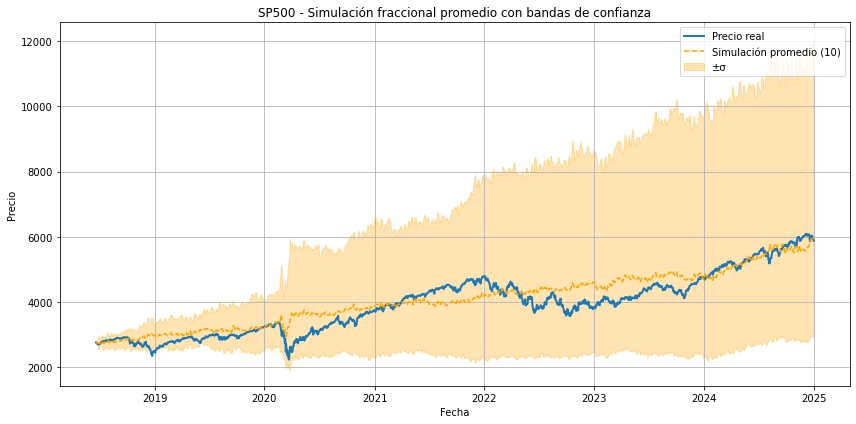


📊 Evaluación para XLB:
  RMSE: 370.9061
  MAE: 297.0734
  R2: 0.8293


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds

# --- 1. Preparación de datos ---
prices_SP_1824 = prices_SP.iloc[-1644:]
log_prices_1824 = np.log(prices_SP_1824).dropna()
log_returns_1824 = log_prices_1824.diff().dropna()

# --- 2. Estimar mu, sigma sobre log-retornos ---
mu = log_returns_1824.mean().values[0]
sigma = log_returns_1824.std().values[0]

# --- 3. Estimar Hurst y alpha ---
H = nolds.hurst_rs(log_returns_1824.values.flatten())
print(f"H estimado: {H:.3f}")
alpha = H
print(f"α = {alpha:.3f}")

# --- 4. Función para obtener pesos Grünwald-Letnikov ---
def grunwald_weights(alpha, N):
    weights = [1.0]
    for k in range(1, N):
        w_k = (1 - (alpha + 1) / k) * weights[-1]
        weights.append(w_k)
    return np.array(weights)

# --- 5. Parámetros de simulación ---
T = len(log_returns_1824)
Δt = 1.0
np.random.seed(25)
n_simulaciones = 15
log_price_sims = []

# Definimos fechas del shock de COVID
covid_start = pd.to_datetime("2020-02-20")
covid_end = pd.to_datetime("2020-04-30")
covid_mask = (log_returns_1824.index >= covid_start) & (log_returns_1824.index <= covid_end)
covid_indices = np.where(covid_mask)[0]

# --- 6. Bucle de simulaciones ---
for i in range(n_simulaciones):
    w = grunwald_weights(alpha, T)
    
    # Simular log-retornos con memoria:
    
    # Inicialización
    log_ret_sim = np.zeros(T)
    log_ret_sim[0] = log_returns_1824.iloc[0].values[0]
    
    # Recorremos la malla temporal con un bucle (día a día)
    for t in range(1, T):
        # Definimos la parte temporal fraccionaria, ponderada por los pesos de Grünwald
        D_alpha = np.sum(w[:t] * log_ret_sim[t-1::-1]) / (Δt ** alpha)
        
        # Shock de COVID
        if t in covid_indices:
            mu_eff = mu - mu*0.15
            sigma_eff = sigma * 5
        else:
            mu_eff = mu
            sigma_eff = sigma
        
        # Generamos el ruido como una normal(0,1)
        noise = np.random.normal(0, 1)
        
        # Aplicamos el modelo recursivo sobre los log-retornos
        #log_ret_sim[t] = (mu_eff + sigma_eff * noise) * Δt + D_alpha
        log_ret_sim[t] = ((mu_eff + sigma_eff * noise) + D_alpha)*(Δt ** alpha)

    # Integrar log-retornos para obtener log-precios
    log_price_sim = np.zeros(T)
    log_price_sim[0] = log_prices_1824.iloc[0].values[0]

    for t in range(1, T):
        log_price_sim[t] = log_price_sim[t-1] + log_ret_sim[t]

    log_price_sims.append(log_price_sim)
    
log_price_sims = np.array(log_price_sims)
    
# --- 7. Promedio y bandas de confianza ---
mean_log_price_sim = log_price_sims.mean(axis=0)
std_log_price_sim = log_price_sims.std(axis=0)

# Insertar valor inicial
mean_log_price_sim = np.insert(mean_log_price_sim, 0, log_prices_1824.iloc[0].values[0])
std_log_price_sim = np.insert(std_log_price_sim, 0, 0)

# Convertir a precios reales
price_sim = np.exp(mean_log_price_sim)
price_sim_upper = np.exp(mean_log_price_sim + std_log_price_sim)
price_sim_lower = np.exp(mean_log_price_sim - std_log_price_sim)

# --- 8. Graficar ---
plt.figure(figsize=(12, 6))
plt.plot(prices_SP_1824.index, prices_SP_1824.values, label='Precio real', linewidth=2)
plt.plot(prices_SP_1824.index, price_sim, label='Simulación promedio (10)', linestyle='--', color='orange')
plt.fill_between(prices_SP_1824.index, price_sim_lower, price_sim_upper, color='orange', alpha=0.3, label='±σ')
plt.title("SP500 - Simulación fraccional promedio con bandas de confianza")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 9. Métricas del modelo ---
y_true = prices_SP_1824.values
y_pred = price_sim

print(f"\n📊 Evaluación para {sector}:")
RMSE_value = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"  RMSE: {RMSE_value:.4f}")
MAE_value = mean_absolute_error(y_true, y_pred)
print(f"  MAE: {MAE_value:.4f}")
R2_value = r2_score(y_true, y_pred)
print(f"  R2: {R2_value:.4f}")


In [92]:
sp500_sim = price_sim


📊 Evaluación para XLY:
  RMSE: 48.9654
  MAE: 37.3333
  R2: -1.3741


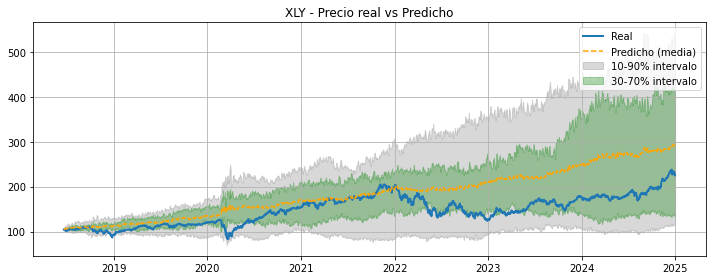


📊 Evaluación para XLK:
  RMSE: 26.9295
  MAE: 20.6796
  R2: 0.6964


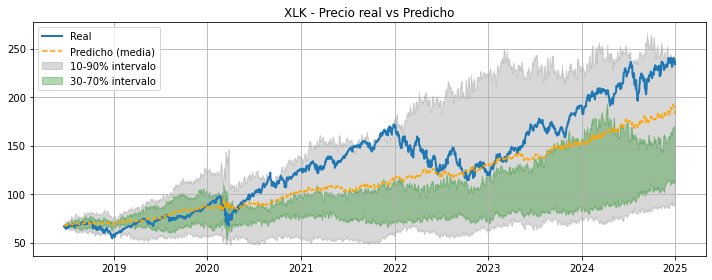


📊 Evaluación para XLC:
  RMSE: 9.6336
  MAE: 8.0636
  R2: 0.5683


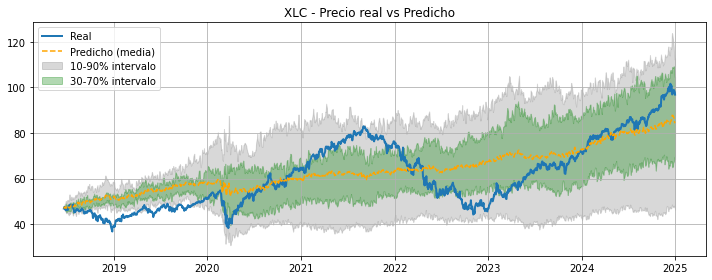


📊 Evaluación para XLU:
  RMSE: 4.7223
  MAE: 3.8865
  R2: 0.7103


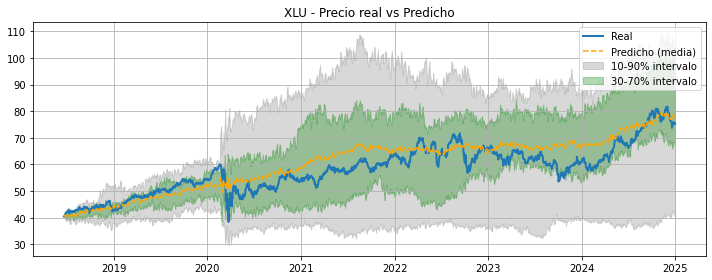


📊 Evaluación para XLV:
  RMSE: 6.9787
  MAE: 5.5462
  R2: 0.9044


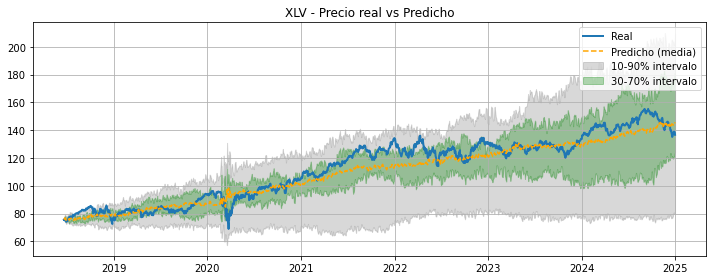


📊 Evaluación para XLRE:
  RMSE: 4.1304
  MAE: 3.4975
  R2: 0.3731


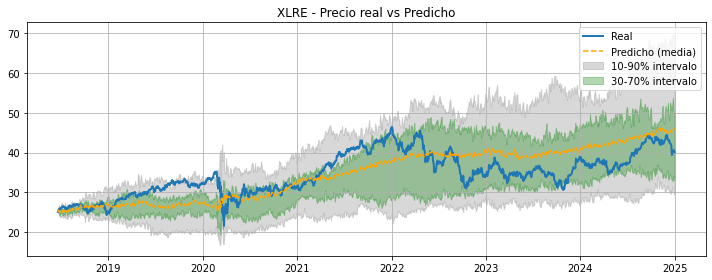


📊 Evaluación para XLE:
  RMSE: 42.4573
  MAE: 38.8982
  R2: -3.3623


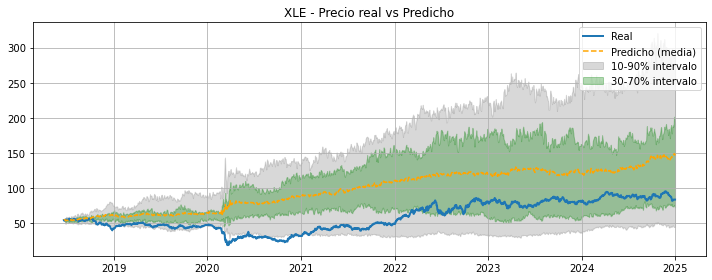


📊 Evaluación para XLF:
  RMSE: 8.3509
  MAE: 6.9641
  R2: -0.3849


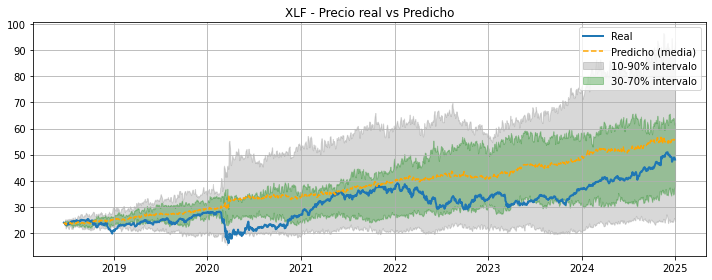


📊 Evaluación para XLI:
  RMSE: 9.7333
  MAE: 7.5688
  R2: 0.7778


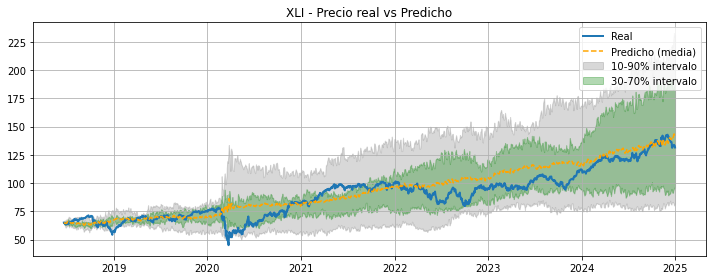


📊 Evaluación para XLB:
  RMSE: 7.8428
  MAE: 6.0950
  R2: 0.7271


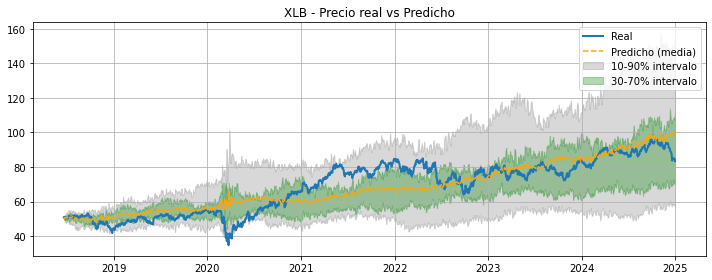

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------
# PARÁMETROS INICIALES
# -----------------------
T = 1644  # días hábiles desde 2018 a 2024
N_t = T
N_x = len(ordered_symbols)
Delta_t = 1.0
Delta_x = 1.0
kappa = kappa_estimate
N_sim = 15  # Número de simulaciones
np.random.seed(6)  # Semilla para reproducibilidad

# -----------------------
# PESOS DE MEMORIA
# -----------------------
# Precalcular los pesos de Grünwald-Letnikov por sector
weight_dict = {}
for j, sector in enumerate(ordered_symbols):
    alpha_j = hurst_dict[sector]
    weights = [1.0]
    for k in range(1, N_t):
        w_k = (1 - (alpha_j + 1) / k) * weights[-1]
        weights.append(w_k)
    weight_dict[sector] = np.array(weights)


# Definir las fechas de impacto del COVID
# -----------------------
covid_start = pd.to_datetime("2020-02-20")
covid_end = pd.to_datetime("2020-03-30")
covid_mask = (sector_returns.index >= covid_start) & (sector_returns.index <= covid_end)
covid_indices = np.where(covid_mask)[0]

    
# -----------------------
# SIMULACIÓN MULTIPLE
# -----------------------
P_prices_sim = np.zeros((N_sim, N_t, N_x))  # Matriz de simulaciones de precios

for s in range(N_sim):  # s = número de simulación
    P_logret = np.zeros((N_t, N_x))
    P_logret[0, :] = sector_returns.iloc[0].values  # log-retornos iniciales

    for n in range(1, N_t):
        for j in range(N_x):
            sector = ordered_symbols[j]
            alpha_j = hurst_dict[sector]
            w = weight_dict[sector]
            mu = mu_dict[sector]
            sigma = sigma_dict[sector]

            D_alpha_P = np.sum(w[:n] * P_logret[n-1::-1, j]) 
            noise = np.random.normal(0, 1)
            
            # Aplicar efecto del COVID
            if n in covid_indices:
                mu_eff = mu - mu*0.15  # Disminución de un 15% del crecimiento esperado durante COVID
                sigma_eff = sigma * 5  # Aumento de volatilidad durante COVID
            else:
                mu_eff = mu
                sigma_eff = sigma
                
            # Condiciones de frontera tipo Neumann
            if j == 0:
                left = P_logret[n-1, j+1]
                center = P_logret[n-1, j]
                right = P_logret[n-1, j+1]
            elif j == N_x - 1:
                left = P_logret[n-1, j-1]
                center = P_logret[n-1, j]
                right = P_logret[n-1, j-1]
            else:
                left = P_logret[n-1, j-1]
                center = P_logret[n-1, j]
                right = P_logret[n-1, j+1]

            # Término difusivo por diferencias finitas centradas   
            diffusion = kappa * (right - 2 * center + left) / (Delta_x**2)

            # Algoritmo recursivo para los log-retornos
            P_logret[n, j] = ((Delta_t**alpha_j) * (mu_eff + sigma_eff * noise + diffusion)) + D_alpha_P

    # -----------------------
    # CONVERTIR A PRECIOS
    # -----------------------
    P_prices_sim[s, 0, :] = sector_df.iloc[0].values
    for t in range(1, N_t):
        P_prices_sim[s, t, :] = P_prices_sim[s, t-1, :] * np.exp(P_logret[t, :])

# -----------------------
# PROMEDIO DE SIMULACIONES
# -----------------------
P_prices_mean = np.mean(P_prices_sim, axis=0)
dates = sector_returns.index[:N_t]
df_preds = pd.DataFrame(P_prices_mean, columns=ordered_symbols, index=dates)

# Percentiles para ver el rango de las simulaciones
p10 = np.percentile(P_prices_sim, 10, axis=0)
p90 = np.percentile(P_prices_sim, 90, axis=0)
p30 = np.percentile(P_prices_sim, 30, axis=0)
p70 = np.percentile(P_prices_sim, 70, axis=0)

RMSE_list=np.zeros(10)
MSE_list=np.zeros(10)
R2_list=np.zeros(10)

for j, sector in enumerate(ordered_symbols):
    y_true = sector_df[sector].iloc[:N_t].values
    y_pred = df_preds[sector].values

    print(f"\n📊 Evaluación para {sector}:")
    RMSE_list[j] = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"  RMSE: {RMSE_list[j]:.4f}")
    MSE_list[j] = mean_absolute_error(y_true, y_pred)
    print(f"  MAE: {MSE_list[j]:.4f}")
    R2_list[j] = r2_score(y_true, y_pred)
    print(f"  R2: {r2[j]:.4f}")
    

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(dates, y_true, label='Real', linewidth=2)
    plt.plot(dates, y_pred, label='Predicho (media)', linestyle='--', color='orange')
    plt.fill_between(dates, p10[:, j], p90[:, j], color='gray', alpha=0.3, label='10-90% intervalo')
    plt.fill_between(dates, p30[:, j], p70[:, j], color='green', alpha=0.3, label='30-70% intervalo')
    plt.title(f"{sector} - Precio real vs Predicho")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


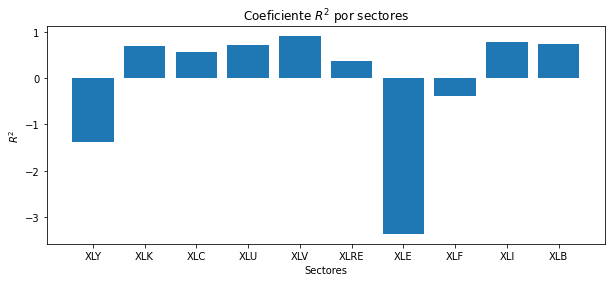

In [94]:
plt.figure(figsize=(10, 4))
plt.bar(ordered_symbols,r2)
plt.title("Coeficiente $R^2$ por sectores")
plt.xlabel("Sectores")
plt.ylabel("$R^2$")
plt.xticks(ordered_symbols)
plt.show()

In [102]:
!pip install tabulate

In [105]:
import pandas as pd
from tabulate import tabulate

# Sector único
sectores = ['S&P500']

# Parámetros con letras griegas
parametros = ['α', 'μ', 'σ', 'MAE', 'RMSE', 'R²']

# Crear tabla vacía
tabla = pd.DataFrame(index=parametros, columns=sectores)

# Rellenar la tabla
tabla.at['α', 'S&P500'] = H
tabla.at['μ', 'S&P500'] = mu
tabla.at['σ', 'S&P500'] = sigma
tabla.at['MAE', 'S&P500'] = MAE_value
tabla.at['RMSE', 'S&P500'] = RMSE_value
tabla.at['R²', 'S&P500'] = R2_value

# Mostrar tabla bonita
print(tabulate(tabla, headers='keys', tablefmt='grid', floatfmt=".4f"))

+------+----------+
|      |   S&P500 |
+======+==========+
| α    |   0.4636 |
+------+----------+
| μ    |   0.0005 |
+------+----------+
| σ    |   0.0126 |
+------+----------+
| MAE  | 297.0734 |
+------+----------+
| RMSE | 370.9061 |
+------+----------+
| R²   |   0.8293 |
+------+----------+


In [106]:
import pandas as pd
from tabulate import tabulate

# Sectores
sectores = ['XLY', 'XLK', 'XLC', 'XLU', 'XLV', 'XLRE', 'XLE', 'XLF', 'XLI', 'XLB']

# Parámetros con letras griegas
parametros = ['α', 'μ', 'σ', 'MAE', 'RMSE', 'R²']

# Crear tabla vacía
tabla = pd.DataFrame(index=parametros, columns=sectores)

# Rellenar la tabla
for i, sector in enumerate(sectores):
    tabla.at['α', sector] = hurst_dict[sector]
    tabla.at['μ', sector] = mu_dict[sector]
    tabla.at['σ', sector] = sigma_dict[sector]
    tabla.at['MAE', sector] = MSE_list[i]
    tabla.at['RMSE', sector] = RMSE_list[i]
    tabla.at['R²', sector] = R2_list[i]

# Imprimir tabla bonita
print(tabulate(tabla, headers='keys', tablefmt='grid', floatfmt=".4f"))


+------+---------+---------+--------+--------+--------+--------+---------+---------+--------+--------+
|      |     XLY |     XLK |    XLC |    XLU |    XLV |   XLRE |     XLE |     XLF |    XLI |    XLB |
+======+=========+=========+========+========+========+========+=========+=========+========+========+
| α    |  0.5216 |  0.5761 | 0.5448 | 0.4886 | 0.5329 | 0.5062 |  0.5775 |  0.5398 | 0.5476 | 0.5412 |
+------+---------+---------+--------+--------+--------+--------+---------+---------+--------+--------+
| μ    |  0.0005 |  0.0008 | 0.0004 | 0.0004 | 0.0004 | 0.0003 |  0.0003 |  0.0004 | 0.0004 | 0.0003 |
+------+---------+---------+--------+--------+--------+--------+---------+---------+--------+--------+
| σ    |  0.0153 |  0.0167 | 0.0146 | 0.0134 | 0.0111 | 0.0146 |  0.0212 |  0.0154 | 0.0138 | 0.0142 |
+------+---------+---------+--------+--------+--------+--------+---------+---------+--------+--------+
| MAE  | 37.3333 | 20.6796 | 8.0636 | 3.8865 | 5.5462 | 3.4975 | 38.8982 

In [98]:
# Reconstrucción del precio del SP500 simulado a partir de los ETFs del modelo fraccionario

print(P_prices_mean.shape)
print(P_prices_sim[:,:,:].shape)
# ejemplo_sim_sectors = P_prices_sim[5,:,:], ejemplo para probar una única simulación (sin hacer la media entre simulaciones)
ejemplo_sim_sectors = P_prices_mean # simulación por sectores, con las simulaciones promediadas

(1644, 10)
(15, 1644, 10)


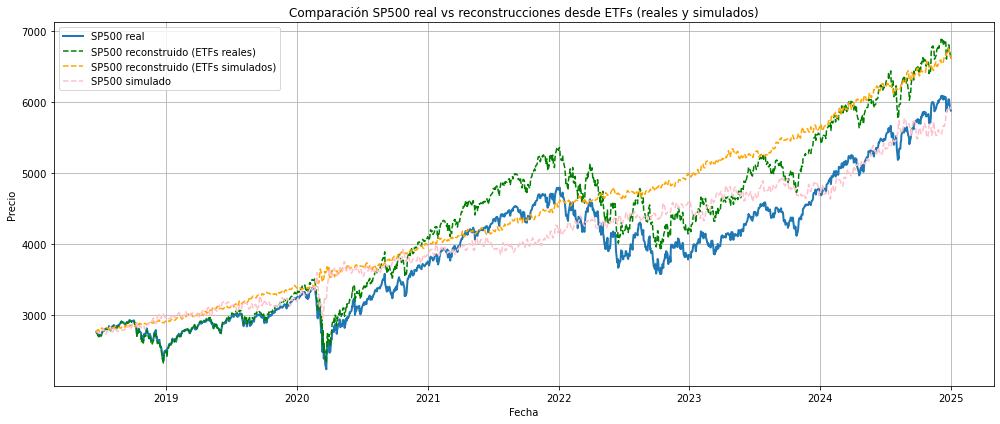


📊 Evaluación para modelo de precios simulados del SP500:
  RMSE: 367.8724
  MAE: 295.0261
  R2: 0.8321

📊 Evaluación para modelo reconstrucción SP500 con precios de sectores simulados:
  RMSE: 383.2166
  MAE: 302.1083
  R2: 0.8878


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Pesos sectoriales ---
weights = np.array([0.11, 0.28, 0.10, 0.03, 0.13, 0.03, 0.04, 0.23, 0.09, 0.06])
weights = weights / np.sum(weights)

# --- 2. Reconstrucción desde datos reales de ETFs ---
sectors_real_aligned = sector_df.iloc[-1644:]
sp500_real_etfs = sectors_real_aligned.values @ weights.reshape(-1, 1)

# --- 3. Reconstrucción desde datos simulados de ETFs ---
sp500_sim_etfs = ejemplo_sim_sectors @ weights.reshape(-1, 1)

# --- 4. Escalar ambas reconstrucciones para que arranquen desde el mismo nivel que el SP500 real ---
initial_value = prices_SP_1824.iloc[0].values[0]
scale_real = initial_value / sp500_real_etfs[0, 0]
scale_sim = initial_value / sp500_sim_etfs[0, 0]

sp500_real_etfs_scaled = sp500_real_etfs * scale_real
sp500_sim_etfs_scaled = sp500_sim_etfs * scale_sim

# --- 5. Graficar las tres series ---
plt.figure(figsize=(14, 6))

plt.plot(prices_SP_1824.index, prices_SP_1824.values, label='SP500 real', linewidth=2)
plt.plot(prices_SP_1824.index, sp500_real_etfs_scaled, 
         label='SP500 reconstruido (ETFs reales)', linestyle='--', color='green')
plt.plot(prices_SP_1824.index, sp500_sim_etfs_scaled, 
         label='SP500 reconstruido (ETFs simulados)', linestyle='--', color='orange')
plt.plot(prices_SP_1824.index, sp500_sim, 
         label='SP500 simulado', linestyle='--', color='pink')

plt.title("Comparación SP500 real vs reconstrucciones desde ETFs (reales y simulados)")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# --- 6. Análisis del modelo (métricas) ---
y_true1 = prices_SP_1824.values
y_true2 = sp500_real_etfs_scaled
y_pred1 = sp500_sim
y_pred2 = sp500_sim_etfs_scaled

print(f"\n📊 Evaluación para modelo de precios simulados del SP500:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true1, y_pred1)):.4f}")
print(f"  MAE: {mean_absolute_error(y_true1, y_pred1):.4f}")
print(f"  R2: {r2_score(y_true1, y_pred1):.4f}")

print(f"\n📊 Evaluación para modelo reconstrucción SP500 con precios de sectores simulados:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true2, y_pred2)):.4f}")
print(f"  MAE: {mean_absolute_error(y_true2, y_pred2):.4f}")
print(f"  R2: {r2_score(y_true2, y_pred2):.4f}")